# Chapter 9: Classical Machine Learning Methods in Image Processing

## Build Model và Triển khai ứng dụng Phân loại giới tính (CNN-Keras)

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np
import glob
import os
import cv2
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import random

## BlockCode 1: Tiền xử lý 2021 ảnh gồm nam và nữ, đưa các ảnh về 1 kich thước duy nhất, gán nhán cho từng ảnh, chia các tập dữ liệu huấn luyện 80% cho train còn 20% sẽ là test, Chuẩn hóa giá trị pixel của ảnh từ khoảng [0, 255] về [0, 1], giúp mô hình hội tụ nhanh hơn khi huấn luyện


*   **Tải dữ liệu**: Đọc các ảnh từ thư mục theo từng nhóm (nam và nữ).
    
*   **Tiền xử lý ảnh**: Chuyển đổi ảnh về kích thước cố định và chuẩn hóa giá trị pixel để đảm bảo nhất quán và tối ưu cho mô hình học sâu.
    
*   **Gắn nhãn**: Mỗi ảnh được gán nhãn tương ứng (1 cho nam, 0 cho nữ) để phục vụ cho bài toán phân loại.
    
*   **Chuyển đổi định dạng**: Dữ liệu được chuyển sang dạng mảng NumPy để dễ dàng sử dụng trong các mô hình học máy.
    
*   **Chia tập dữ liệu**: Phân chia dữ liệu thành hai phần: tập huấn luyện (train) và tập kiểm tra (test) để mô hình có thể học và đánh giá hiệu quả.

In [24]:
path = 'Training'
images = []
labels = []


male_files = glob.glob(os.path.join(path, 'male', '*.jpg'))
for file in male_files:
    img = cv2.imread(file)
    img = cv2.resize(img, (130, 130))
    images.append(img)
    labels.append(1)  


female_file = glob.glob(os.path.join(path, 'female', '*.jpg'))
for file in female_file:
    img = cv2.imread(file)
    img = cv2.resize(img, (130, 130))
    images.append(img)
    labels.append(0)

# Convert to numpy arrays and normalize images to 0-1 range
images = np.array(images) / 255.0
labels = np.array(labels)

print(len(images))

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

2021



* **glob.glob()** : Lấy danh sách tất cả các file .jpg trong thư mục Training/male.

*   **cv2.imread()**: Đọc ảnh từ đường dẫn.
    
*   **cv2.resize()**: Chuyển ảnh về kích thước cố định 130x130 pixel để đảm bảo tất cả ảnh có kích thước đầu vào đồng nhất.
    
*   **images.append(img)**: Thêm ảnh đã xử lý vào danh sách images.
    
*   **labels.append(1)**: Gán nhãn 1 (tương ứng với nam) cho ảnh và thêm vào danh sách labels.

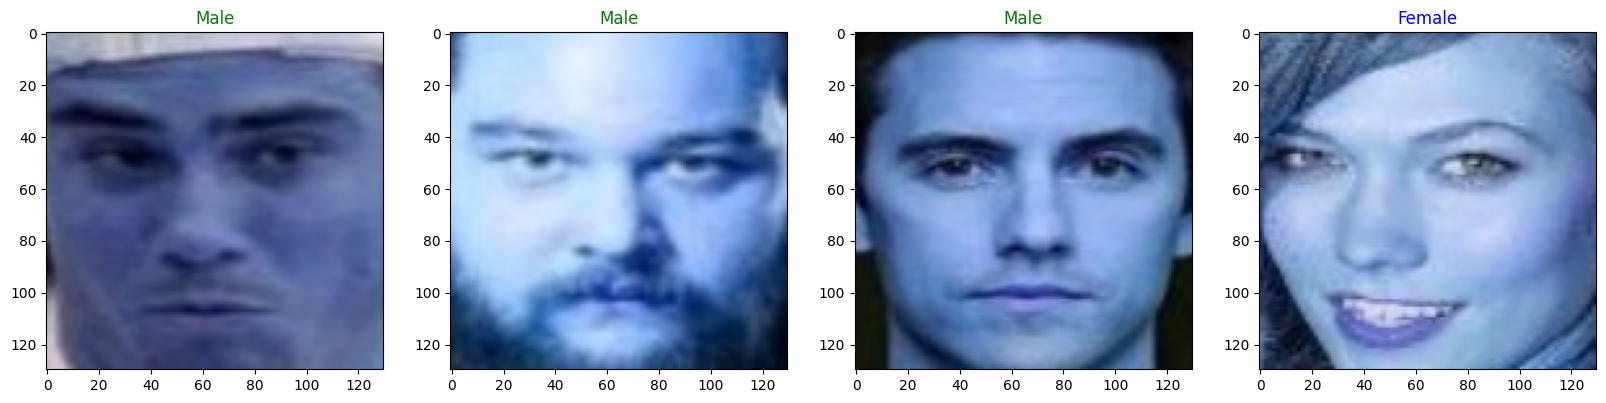

In [25]:
plt.figure(figsize=(20,8))
for i in range(4):
    plt.subplot(1,4,i+1)
    index=random.randint(0,len(images))
    gender=labels[index]
    plt.imshow(images[index])
    if gender==1:
        plt.title("Male", color='green')
    else :
        plt.title("Female", color='blue')

## BlockCode 2: Giải thích các lớp có trong model

### **1\. Conv2D (Lớp tích chập)**

*   Lớp Conv2D sử dụng các **bộ lọc (filters)** để phát hiện các đặc trưng (features) quan trọng trong ảnh, chẳng hạn như:
    
    *   Đường biên.
        
    *   Cạnh, góc.
        
    *   Mẫu (pattern), hình dạng phức tạp.
        
*   Mỗi bộ lọc tập trung vào một loại đặc trưng khác nhau. Ví dụ:
    
    *   Một bộ lọc phát hiện cạnh ngang.
        
    *   Một bộ lọc phát hiện cạnh dọc.
        
    *   Một bộ lọc phát hiện đường cong.

#### **Cách hoạt động**:

*   **Đầu vào**:
    
    *   Lớp này nhận một tensor 4 chiều, có kích thước (batch\_size,height,width,channels)(batch\\\_size, height, width, channels)(batch\_size,height,width,channels):
        
        *   **height và width**: Kích thước không gian của ảnh đầu vào.
            
        *   **channels**: Số kênh màu, thường là 3 (RGB) cho ảnh màu hoặc 1 cho ảnh đen trắng.
            
        *   **batch\_size**: Số lượng ảnh xử lý cùng lúc (tùy thuộc batch size trong huấn luyện).
            
    *   Ví dụ:
        
        *   Lớp đầu tiên có đầu vào là ảnh (130,130,3).
            
*   **Hoạt động**:
    
    *   Sử dụng các **kernel** (bộ lọc nhỏ, ví dụ: 3x3).
        
    *   **Kernel trượt qua ảnh**, tính toán tích chập (convolution) giữa kernel và vùng tương ứng trên ảnh.
        
    *   Kết quả là một **map đặc trưng** (feature map) mô tả các đặc điểm cụ thể trong ảnh, như cạnh, góc, hoặc hoa văn.
        
*   **Đầu ra**:
    
    *   Kích thước đầu ra phụ thuộc vào:
        
        *   Kích thước kernel.
            
        *   **Padding** (thêm pixel vào biên ảnh).
            
        *   **Stride** (bước di chuyển của kernel).

### **2\. MaxPooling2D (Lớp pooling tối đa)**


MaxPooling2D là một lớp dùng để giảm kích thước của dữ liệu không gian (chiều cao và chiều rộng) nhưng vẫn giữ lại các đặc trưng quan trọng. Điều này được thực hiện thông qua down-sampling (lấy mẫu xuống) bằng cách áp dụng một cửa sổ (kernel) và chọn giá trị lớn nhất trong cửa sổ đó.

#### **Cách hoạt động**:

*   **Đầu vào**:
    
    *   Nhận map đặc trưng từ lớp trước, ví dụ: (128,128,32).
        
*   **Hoạt động**:
    
    *   Chia map đặc trưng thành các ô nhỏ .
        
    *   Trong mỗi ô, lấy **giá trị lớn nhất** (max pooling), đại diện cho vùng đó.
        
    *   Điều này giúp giảm kích thước map, giảm số lượng tham số và tính toán, đồng thời giữ thông tin quan trọng.
        
*   **Đầu ra**:
    
    *   Kích thước không gian giảm một nửa:
        
        *   Ví dụ: (128,128,32)→(64,64,32).
            
    *   Số kênh (32) không đổi vì không thêm bộ lọc mới.

### **3\. Flatten (Làm phẳng dữ liệu)**

#### **Cách hoạt động**:

*   **Đầu vào**:
    
    *   Tensor 3D, ví dụ: (14,14,128), với:
        
        *   14x14: Kích thước không gian.
            
        *   128: Số kênh từ map đặc trưng cuối cùng.
            
*   **Hoạt động**:
    
    *   Chuyển tensor 3D thành vector 1D:
        
        *   14×14×128=25,088.
            
    *   Làm phẳng dữ liệu để chuẩn bị đưa vào các lớp fully connected.
        
*   **Đầu ra**:
    
    *   Vector 1D: (25088,)phù hợp để sử dụng trong các lớp Dense.


### **4\. Dense (Lớp fully connected)**

#### **Cách hoạt động**:

*   **Đầu vào**:
    
    *   Vector 1D từ lớp Flatten, ví dụ: (25088,).
        
*   **Hoạt động**:
    
    *   Kết nối toàn bộ đầu vào với từng neuron trong lớp Dense.
        
    *   Mỗi neuron thực hiện:
        
        *   Tính tích có trọng số: z=w*x+b.
            
        *   Áp dụng hàm kích hoạt (ReLU hoặc Sigmoid) để đưa ra đầu ra phi tuyến tính.
            
    *   **Dense(128)**: Kết nối 25,088 đầu vào tới 128 neuron.
        
*   **Đầu ra**:
    
    *   Vector 1D: (128,) từ lớp Dense đầu tiên.
        
    *   Vector 1D: (1,) từ lớp Dense cuối cùng (vì đây là bài toán phân loại nhị phân).


### **5\. Dropout**

#### **Cách hoạt động**:

*   **Đầu vào**:
    
    *   Vector từ lớp Dense trước đó, ví dụ: (128,).
        
*   **Hoạt động**:
    
    *   Trong quá trình huấn luyện, **ngẫu nhiên bỏ qua** (tắt) một tỷ lệ (50%) neuron để:
        
        *   Giảm overfitting.
            
        *   Tăng khả năng khái quát hóa của mô hình.
            
*   **Đầu ra**:
    
    *   Vector (128,),với một số giá trị được đặt thành 0.

In [26]:
# Create the Model
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(130, 130, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model()
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## BlockCode 3: Train Model với các tập dữ liệu với 32 epochs

In [27]:
# Train the Model

history = model.fit(train_data, train_labels, epochs=32, validation_data=(test_data, test_labels))
model.save('gender_model.h5')

Epoch 1/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5391 - loss: 0.7135 - val_accuracy: 0.5481 - val_loss: 0.9726
Epoch 2/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7134 - loss: 0.6104 - val_accuracy: 0.8198 - val_loss: 0.4170
Epoch 3/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8183 - loss: 0.4030 - val_accuracy: 0.7901 - val_loss: 0.4537
Epoch 4/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8641 - loss: 0.3373 - val_accuracy: 0.8593 - val_loss: 0.3852
Epoch 5/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8784 - loss: 0.3068 - val_accuracy: 0.8716 - val_loss: 0.3421
Epoch 6/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9115 - loss: 0.2285 - val_accuracy: 0.8543 - val_loss: 0.3582
Epoch 7/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8888 - loss: 0.2434 - val_accuracy: 0.9012 - val_loss: 0.2581
Epoch 8/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9319 - loss: 0.1809 - val_accuracy: 0.9037 - v

## Blockcode 4: Đánh Giá Quá Trình Train, Độ chính xác của model với các tập dữ liệu train và test

Text(0.5, 1.0, ' accuracy VS val_accuracy ')

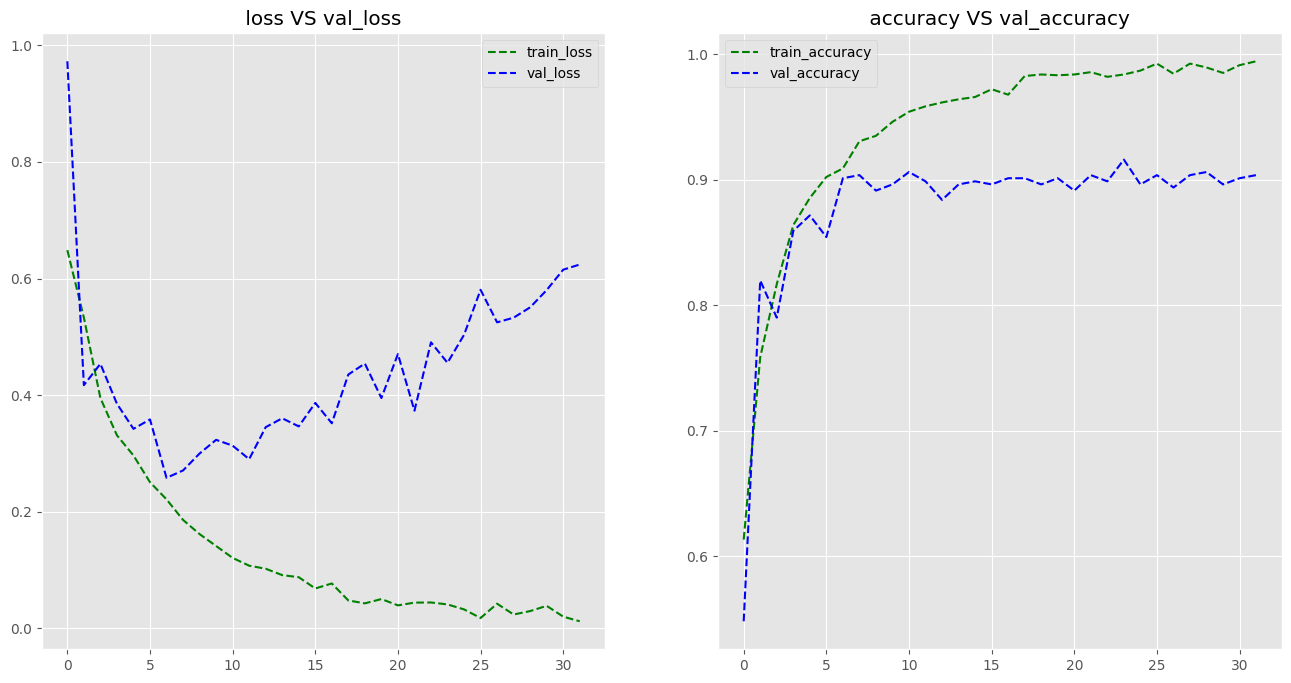

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linestyle='--', color='green', label='train_loss')
plt.plot(history.history['val_loss'], linestyle='--', color='blue', label='val_loss')
plt.legend()
plt.title(" loss VS val_loss ")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linestyle='--', color='green', label='train_accuracy')
plt.plot(history.history['val_accuracy'], linestyle='--', color='blue', label='val_accuracy')
plt.legend()
plt.title(" accuracy VS val_accuracy ")

In [ ]:
prediction=model.predict(test_data)
print(prediction)


In [30]:
test_data.shape

(405, 130, 130, 3)

In [ ]:
predictions=prediction>=0.5
print(predictions)
predict=predictions.astype(int)


## BlockCode 5: Sử dụng mô hình vừa train để dự đoán ảnh

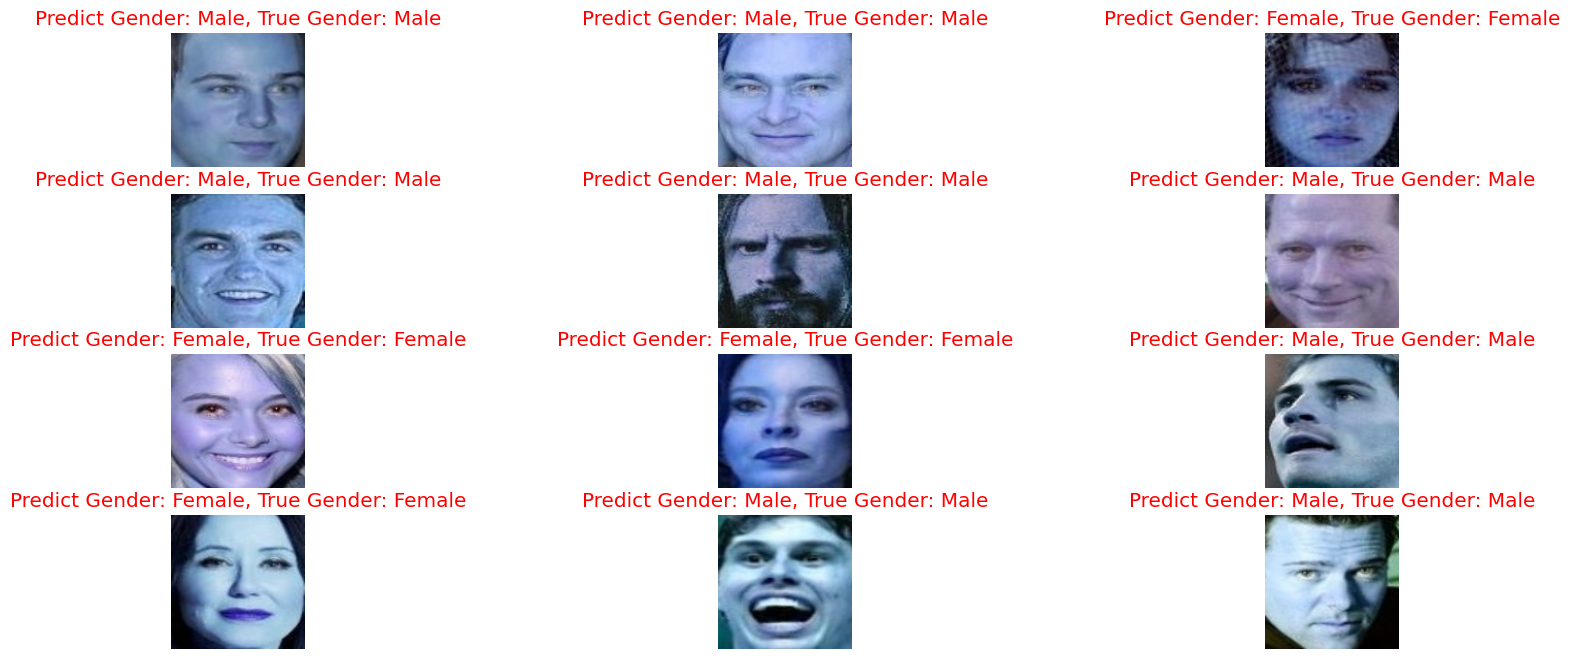

In [57]:
plt.figure(figsize=(20,8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.axis(False)
    index = random.randint(0, len(test_data)-1)
    plt.imshow(test_data[index])
    plt.title(f"Predict Gender: {'Male' if predict[index][0] == 1 else 'Female'}, True Gender: {'Male' if test_labels[index] == 1 else 'Female'}", color='red')

## Xây dựng ứng dụng

In [60]:
import os
import cv2
import numpy as np
from tkinter import *
from tkinter import filedialog
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageTk

# Load the trained model
model = load_model('gender_model.h5')

# Function to predict gender
def predict_gender(img_path):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (130, 130))  # Resize to match the model input size
    img = np.array(img) / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)
    
    # Return 'Male' or 'Female' based on prediction
    return 'Male' if prediction[0] > 0.5 else 'Female'




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


*   **img = cv2.imread(img\_path)**: Dùng OpenCV để đọc tệp ảnh từ đường dẫn img\_path.
    
*   **img = cv2.resize(img, (130, 130))**: Đổi kích thước ảnh về kích thước mà mô hình yêu cầu, ở đây là 130x130 pixel.
    
*   **img = np.array(img) / 255.0**: Chuyển ảnh thành mảng NumPy và chuẩn hóa giá trị pixel trong ảnh (giảm giá trị từ 0-255 xuống 0-1 để phù hợp với yêu cầu của mô hình).
    
*   **img = np.expand\_dims(img, axis=0)**: Thêm một chiều vào mảng ảnh để phù hợp với yêu cầu đầu vào của mô hình, mô hình Keras yêu cầu đầu vào có dạng (batch\_size, height, width, channels), nơi batch\_size là số lượng ảnh, nhưng ta chỉ có một ảnh, nên thêm chiều 0 vào.
    
*   **prediction = model.predict(img)**: Dự đoán giới tính của ảnh bằng mô hình đã được huấn luyện (model.predict()).
    
*   **return 'Male' if prediction\[0\] > 0.5 else 'Female'**: Dựa trên giá trị dự đoán, trả về "Male" nếu xác suất cao hơn 0.5 (tức là dự đoán là nam), hoặc "Female" nếu thấp hơn 0.5.

In [ ]:
def select_folder():
    folder_path = filedialog.askdirectory()  
    if folder_path:
        display_images(folder_path)


def display_images(folder_path):

    for widget in frame.winfo_children():
        widget.destroy()

    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        

        gender = predict_gender(img_path)

        img = Image.open(img_path)
        img = img.resize((150, 150)) 
        img_tk = ImageTk.PhotoImage(img)
        
     
        label_img = Label(frame, image=img_tk)
        label_img.image = img_tk  
        label_img.grid(row=image_files.index(img_file), column=0)
        
        label_text = Label(frame, text=gender, font=('Helvetica', 10, 'bold'))
        label_text.grid(row=image_files.index(img_file), column=1)


root = Tk()
root.title('Gender Prediction from Images')
root.geometry('800x600')


frame = Frame(root)
frame.pack(pady=20)


select_folder_btn = Button(root, text="Select Folder", command=select_folder, font=('Helvetica', 12))
select_folder_btn.pack(pady=10)


root.mainloop()

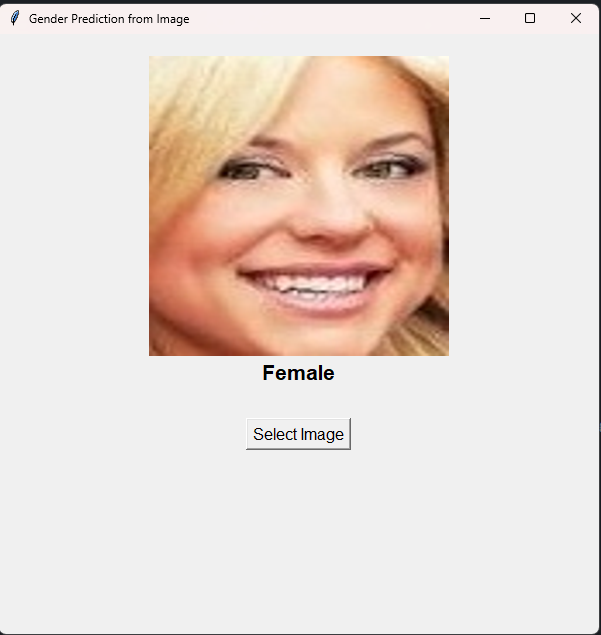